Installation requirements:

1. pip3: '''sudo apt-get install python3-pip'''
2. TensorFlow: '''sudo pip3 install tensorflow'''
3. Keras: '''pip install keras'''

In [99]:
# import modules
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# read the data

data = pd.read_csv('./data/blackberry_1980-2011.txt', skiprows=12, header=0, sep=';', usecols=[0, 1, 2, 4, 5], 
                   names=['Date', 'Qobs', 'Ptot', 'Temp', 'PE'], index_col=0, parse_dates=True)

In [61]:
runoff = data['Qobs'].resample('M').mean()

Problem definition.

One-month ahead forecast:

Runoff(t+1) = f(Runoff(t))

In [62]:
# define one-step lagged runoff (our predictor)
runoff_lag1 = runoff.shift(1).dropna()

In [63]:
# transform variable in common ML notations:

y = runoff.values[1:]
X = runoff_lag1.values

In [64]:
# scaler creation

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [65]:
# define our train and test sets

X_train, y_train = scaler.transform(X[: 300].reshape(-1, 1)), scaler.transform(y[: 300].reshape(-1, 1))
X_test, y_test = scaler.transform(X[300:].reshape(-1, 1)), scaler.transform(y[300:].reshape(-1, 1))

In [66]:
# reshape inputs accordind to TF and Keras requirements:
# input to be [samples, time steps, features]

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [67]:
# create LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [68]:
# fit our LSTM network
model.fit(X_train, y_train, nb_epoch=100)

Epoch 1/100
300/300 [==============================] - 0s - loss: 0.0380     
Epoch 2/100
300/300 [==============================] - 0s - loss: 0.0335     
Epoch 3/100
300/300 [==============================] - 0s - loss: 0.0296     
Epoch 4/100
300/300 [==============================] - 0s - loss: 0.0262     
Epoch 5/100
300/300 [==============================] - 0s - loss: 0.0235     
Epoch 6/100
300/300 [==============================] - 0s - loss: 0.0214     
Epoch 7/100
300/300 [==============================] - 0s - loss: 0.0197     
Epoch 8/100
300/300 [==============================] - 0s - loss: 0.0186     
Epoch 9/100
300/300 [==============================] - 0s - loss: 0.0176     
Epoch 10/100
300/300 [==============================] - 0s - loss: 0.0170     
Epoch 11/100
300/300 [==============================] - 0s - loss: 0.0167     
Epoch 12/100
300/300 [==============================] - 0s - loss: 0.0165     
Epoch 13/100
300/300 [==============================] - 0s - 

In [69]:
# make predictions
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

In [89]:
df_train = pd.DataFrame({'Observed': scaler.inverse_transform(y_train.ravel().reshape(-1, 1)).ravel(), 
                         'Modeled': scaler.inverse_transform(y_train_predict.ravel().reshape(-1, 1)).ravel()}, index = runoff.index[1:301])

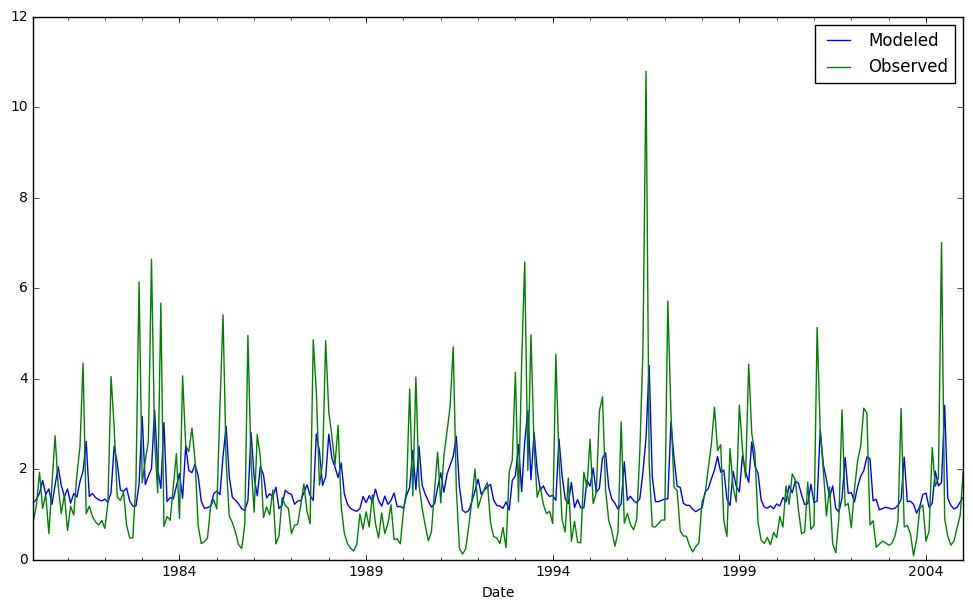

In [94]:
df_train.plot(figsize=(12, 7))

In [95]:
df_test = pd.DataFrame({'Observed': scaler.inverse_transform(y_test.ravel().reshape(-1, 1)).ravel(), 
                         'Modeled': scaler.inverse_transform(y_test_predict.ravel().reshape(-1, 1)).ravel()}, index = runoff.index[301:])

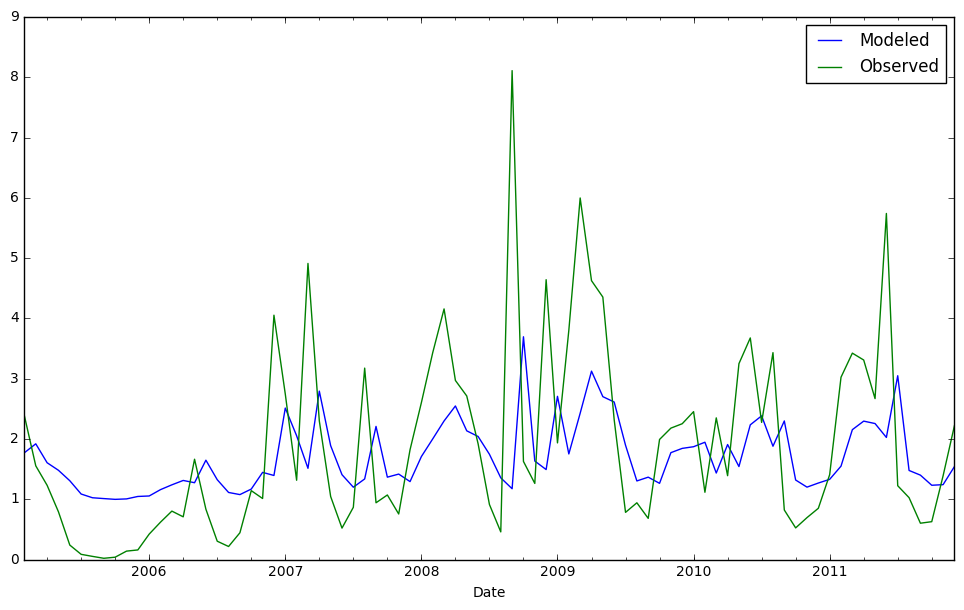

In [96]:
df_test.plot(figsize=(12, 7))

In [97]:
df_train.corr()

,Modeled,Observed
Modeled,1.000000,0.383422
Observed,0.383422,1.000000


In [98]:
df_test.corr()

,Modeled,Observed
Modeled,1.000000,0.406558
Observed,0.406558,1.000000


In [101]:
r2_score(df_train.Observed, df_train.Modeled)

0.14619047018100551

In [102]:
r2_score(df_test.Observed, df_test.Modeled)

0.1501854665236404